# Import Library

In [1]:
# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

# Import necessary libraries for plotting and data manipulation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import Darts library components for time series processing and modeling
from statsmodels.tsa.seasonal import STL
from darts.dataprocessing.transformers import Scaler  
from darts.models import RNNModel
from darts.metrics import mape, rmse, r2_score  
from darts.utils.statistics import check_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries  
from darts import TimeSeries  

# Import time module for tracking execution duration
import time

import joblib

# Suppress warnings to keep output clean
import warnings
warnings.filterwarnings("ignore")

# Disable logging messages at the CRITICAL level or lower
import logging
logging.disable(logging.CRITICAL)

# Suppress Darts logging
logging.getLogger("darts").setLevel(logging.CRITICAL)

# Analyze Data

In [2]:
# Load data and convert to TimeSeries object
df = pd.read_csv('dataset/vietnam_electricity_demand.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
ts = TimeSeries.from_dataframe(df, value_cols='Demand')

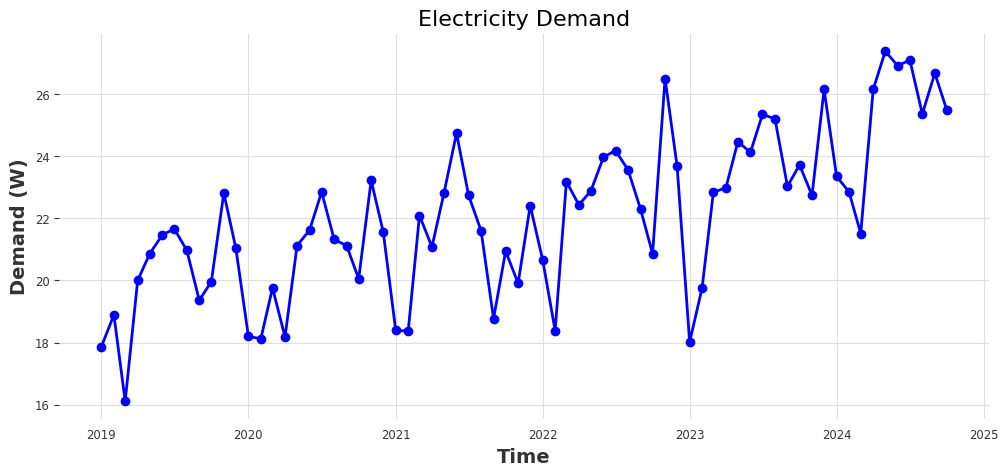

In [3]:
# Plot the observations
plt.figure(figsize=(12, 5))
ts.plot(color='blue', marker='o')
plt.legend().set_visible(False)
plt.title('Electricity Demand', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Demand (W)', fontsize=14)
plt.show()

In [4]:
# Split train - valid - test dataset
FC_START_VALIDATION = "20221201"  
FC_START_TEST = "20231201"        

train, val_temp = ts.split_after(pd.Timestamp(FC_START_VALIDATION))

val, test = val_temp.split_after(pd.Timestamp(FC_START_TEST))

print("Train size:", len(train))
print("Validation size:", len(val))
print("Test size:", len(test))


Train size: 48
Validation size: 12
Test size: 10


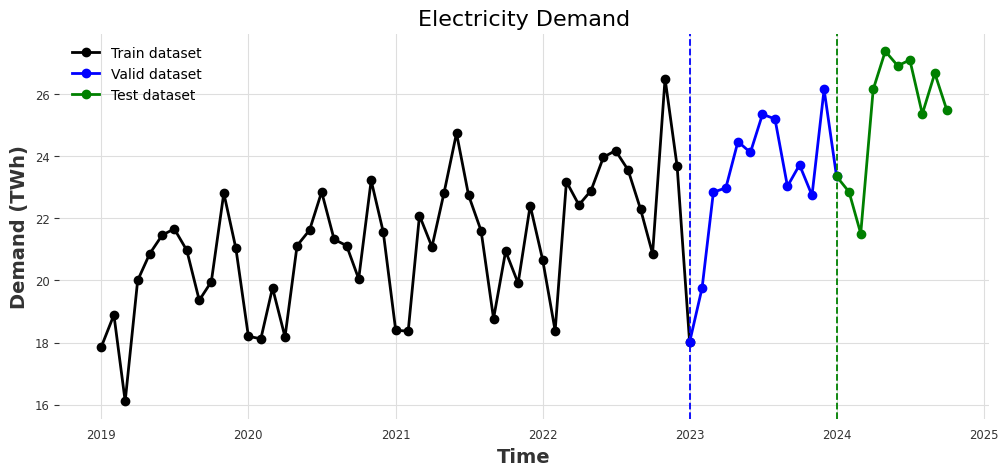

In [5]:
# Plot the division between training and validation datasets
plt.figure(figsize=(12, 5))

split_point_1 = int(len(ts) - len(val) - len(test))  
split_point_2 = int(len(ts) - len(test))

split_time_1 = ts.time_index[split_point_1]
split_time_2 = ts.time_index[split_point_2]

ts_first_part = ts[:split_point_1 + 1]
ts_second_part = ts[split_point_1: int(len(ts) - len(test) + 1)]
ts_third_part = ts[split_point_2:]

ts_first_part.plot(label='Train dataset', marker='o', color='black')
ts_second_part.plot(label='Valid dataset', marker='o', color='blue')
ts_third_part.plot(label='Test dataset', marker='o', color='green')

plt.axvline(x=split_time_1, color='blue', linestyle='--')
plt.axvline(x=split_time_2, color='green', linestyle='--')

plt.title('Electricity Demand', fontsize=16)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('Demand (TWh)', fontsize=14)
plt.show()

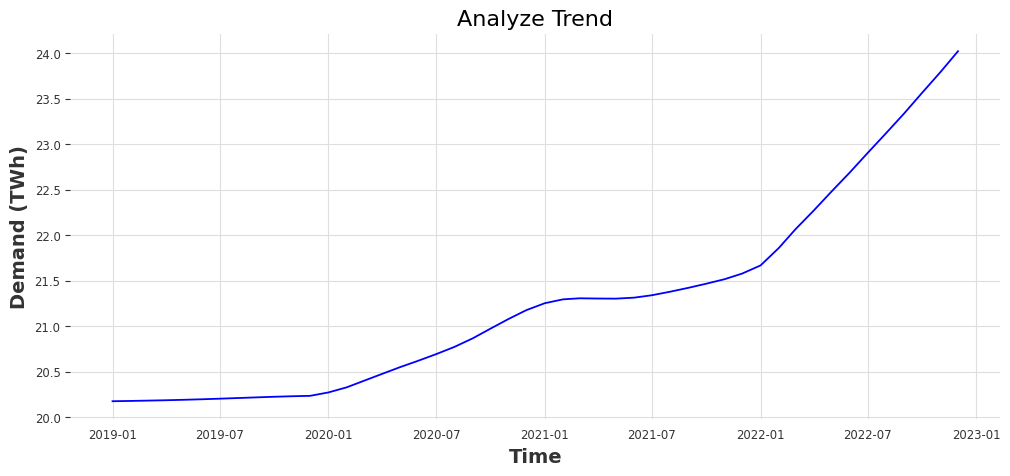

In [6]:
# Analyze Trend
train_df = train.pd_dataframe()
stl = STL(train_df['Demand'])  
result = stl.fit()
plt.figure(figsize=(12, 5))
plt.plot(result.trend, color='blue')
plt.title('Analyze Trend', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Demand (TWh)', fontsize=14)
plt.show()

is seasonal? : True
periodicity (months) : 7.0
periodicity (~years) : 0.6


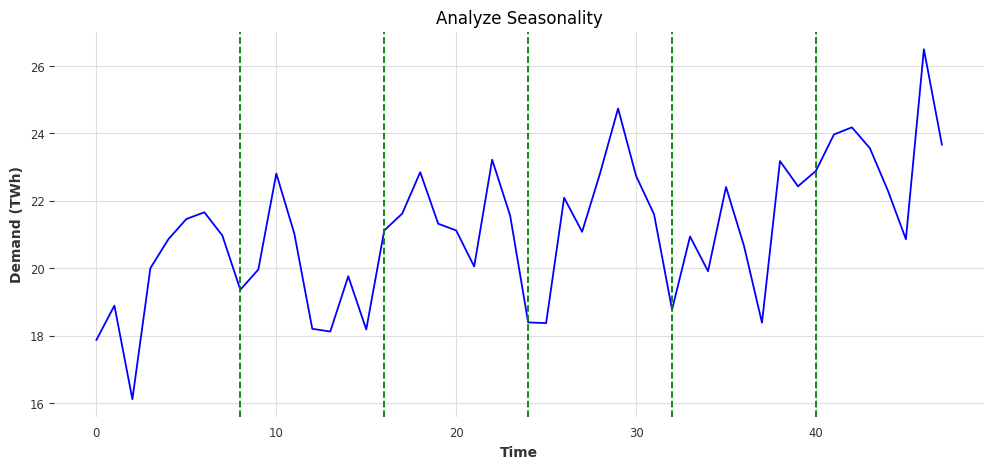

In [7]:
# Analyze seasonality
is_seasonal, periodicity = check_seasonality(train, max_lag=12)
dict_seas = {
    "is seasonal?": is_seasonal, 
    "periodicity (months)": f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'
}
_ = [print(k, ":", v) for k, v in dict_seas.items()]

# Plot the entire time series, concatenating the cycles together
n_periods = int(len(train) / periodicity)  
periods = np.array_split(train.values().flatten(), n_periods)  
combined_periods = np.concatenate(periods)
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(combined_periods)), combined_periods, color='blue')
for i in range(1, len(periods)):
    plt.axvline(x=len(np.concatenate(periods[:i])), color='green', linestyle='--')
plt.title('Analyze Seasonality')
plt.xlabel('Time')
plt.ylabel('Demand (TWh)')
plt.legend()
plt.show()

In [8]:
# Normalize the time series
trf = Scaler()
train_trf = trf.fit_transform(train)
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [9]:
# Extend the original time series (ts) by appending 60 months (5 years) of random data
ts_cov = ts
freq = ts_cov.time_index.inferred_freq  # Infer time series frequency

for i in range(60):
    next_month = ts_cov.time_index[-1] + pd.DateOffset(months=1)
    next_month_index = pd.DatetimeIndex([next_month])
    random_values = 0
    new_ts = TimeSeries.from_times_and_values(next_month_index, random_values, fill_missing_dates=True, freq=freq)
    ts_cov = ts_cov.append(new_ts)

In [10]:
# Load the weather data from a CSV file
weather_df = pd.read_csv('dataset/weather_data.csv')

month_series = datetime_attribute_timeseries(ts_cov, attribute='month', one_hot=True)
# month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)

# Convert the TimeSeries object into a DataFrame
month_series_df = month_series.pd_dataframe()

month_series_df['Month'] = month_series_df.index.month  # Extracts the month from the datetime index

# Ensure the 'Month' column in weather_df is of integer type
weather_df['Month'] = weather_df['Month'].astype(int)

weather_covariates = weather_df[['Month', 'Temp_max_North', 'Temp_min_North', 'Humi_North', 'Rain_North', 'Rain_Days_North', 
                                 'Temp_max_Central', 'Temp_min_Central', 'Humi_Central', 'Rain_Central', 'Rain_Days_Central',
                                 'Temp_max_South', 'Temp_min_South', 'Humi_South', 'Rain_South', 'Rain_Days_South']]

# Merge the month data and weather covariates on the 'Month' column using a left join
merged_covariates = pd.merge(month_series_df, weather_covariates, on='Month', how='left')

# Create a new 'Date' column in merged_covariates from the index of month_series_df
merged_covariates['Date'] = month_series_df.index

# Set 'Date' as the index of merged_covariates
merged_covariates.set_index('Date', inplace=True)

In [11]:
# The DataFrame has combined month and weather information
covariates_ts = TimeSeries.from_dataframe(
    merged_covariates, 
    value_cols=merged_covariates.columns.difference(['Date', 'Month'])  
)
scaler = Scaler()
covariates_ts_scaled = scaler.fit_transform(covariates_ts)
covariates = covariates_ts_scaled

In [12]:
# # No weather data available for this example, so we will use the month data only

# # Derive the month from the date strings
# month_series = datetime_attribute_timeseries(ts, attribute='month', one_hot=True)
# scaler_month = Scaler()
# covariates = scaler_month.fit_transform(month_series)

# Run the Models

In [13]:
show_callback = True

In [14]:
if show_callback:
    from pytorch_lightning.callbacks import Callback

    class LossTracker(Callback):
        def __init__(self):
            super().__init__()
            self.train_losses = []
            self.val_losses = []

        def on_train_epoch_end(self, trainer, pl_module):
            train_loss = trainer.callback_metrics.get("train_loss")
            if train_loss is not None:
                self.train_losses.append(train_loss.item())

        def on_validation_epoch_end(self, trainer, pl_module):
            val_loss = trainer.callback_metrics.get("val_loss")
            if val_loss is not None:
                self.val_losses.append(val_loss.item())

    loss_tracker = LossTracker()

In [15]:
def fit_RNN(model, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0}:".format(flavor))

    res = model.fit(train_trf,
             future_covariates=covariates,
             val_series=val_trf,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [16]:
def plot_fitted(pred, act, model_name):
    act2 = act.slice(act.start_time(), pred.end_time())
    split_point = int(len(act) - len(test) - len(pred))  
    split_time = act2.time_index[split_point]
    act2_first_half = act2[:split_point + 1]
    act2_second_half = act2[split_point:]

    plt.figure(figsize=(12, 5))
    act2_first_half.plot(label='train', marker='o', color='black')
    act2_second_half.plot(label='valid', marker='o', color='blue')
    pred.plot(label='prediction', marker='o', color='green')
    plt.axvline(x=split_time, color='blue', linestyle='--')

    plt_title = "Model: {0}"
    plt.title(plt_title.format(model_name) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Demand (TWh)', fontsize=14)
    plt.show()

In [17]:
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)

    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    res_mape = mape(pred2, act2)

    res_r2 = r2_score(act2, pred2)

    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)     

    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "R squared":res_r2}
    return res_accuracy

In [18]:
import itertools

def grid_search_RNN(param_grid, flavor):
    best_score = float('inf')  
    best_params = None  
    best_model = None  

    # Generate all combinations of the hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    for combination in param_combinations:
        params = dict(zip(param_grid.keys(), combination))
        
        # Create and train the model with the current combination of hyperparameters
        print(f"Training with parameters: {params}")
        model_RNN = RNNModel(
            model=flavor,
            model_name=flavor + str(" RNN"),
            input_chunk_length=periodicity,
            output_chunk_length=1,
            training_length=periodicity + 1,
            n_rnn_layers=params['n_rnn_layers'],
            hidden_dim=params['hidden_dim'],
            batch_size=64,
            n_epochs=184,
            dropout=params['dropout'],
            optimizer_kwargs={'lr': 0.001},
            random_state=42,
            force_reset=True
        )

        # Fit the model
        fit_RNN(model_RNN, flavor)

        # Compute predictions
        pred = model_RNN.predict(len(val), future_covariates=covariates)
        
        # Inverse transform predictions
        pred_inv = [trf.inverse_transform(p) for p in pred] if isinstance(pred, list) else trf.inverse_transform(pred)
        ts_trf_inv = [trf.inverse_transform(t) for t in ts_trf] if isinstance(ts_trf, list) else trf.inverse_transform(ts_trf)

        # Calculate accuracy metrics
        res_acc = accuracy_metrics(pred_inv, ts_trf_inv)
        
        # Extract the MAPE from the accuracy metrics
        mape_score = res_acc["MAPE"]
        
        # Update the best model if the current model has a lower MAPE
        if mape_score < best_score:
            best_score = mape_score
            best_params = params
            best_model = model_RNN

    print(f"Best hyperparameters: {best_params}")
    print(f"Best MAPE score: {best_score:.4f}")

    return best_model, best_params, best_score

In [19]:
# Define your hyperparameters and model flavor
param_grid = {
    'n_rnn_layers': [1, 2, 3],
    'hidden_dim': [64, 128, 175],
    'dropout': [0.2, 0.3, 0.5],
}

# # Call the grid search function
# best_model, best_params, best_score = grid_search_RNN(param_grid, "LSTM")

# # The best model, hyperparameters, and MAPE score are now available
# print(f"Best Model: {best_model}")
# print(f"Best Hyperparameters: {best_params}")
# print(f"Best MAPE Score: {best_score:.4f}")

In [20]:
# print(f"Best Model: {best_model}")
# print(f"Best Hyperparameters: {best_params}")
# print(f"Best MAPE Score: {best_score:.4f}")

In [21]:
def run_RNN(flavor):
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        output_chunk_length = 1,
        training_length=periodicity+1,
        n_rnn_layers=1,
        hidden_dim=175,
        batch_size=64,
        n_epochs=184,
        dropout=0.2,
        optimizer_kwargs={'lr': 0.001}, 
        random_state=42,
        # force_reset=True)
        force_reset=True,
        pl_trainer_kwargs={"callbacks": [loss_tracker]})

    # Fit the model
    fit_RNN(model_RNN, flavor)

    # Compute N predictions
    pred = model_RNN.predict(len(val), future_covariates=covariates) 

    # Recover predicted values ​​from normalized data for each individual Time Series
    pred_inv = [trf.inverse_transform(p) for p in pred] if isinstance(pred, list) else trf.inverse_transform(pred)

    # Recover predicted values ​​from normalized data for each individual Time Series
    ts_trf_inv = [trf.inverse_transform(t) for t in ts_trf] if isinstance(ts_trf, list) else trf.inverse_transform(ts_trf)

    # Plot predictions vs actual
    plot_fitted(pred_inv, ts_trf_inv, flavor)

    # Print accuracy metrics
    res_acc = accuracy_metrics(pred_inv, ts_trf_inv)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return res_acc, model_RNN


beginning the training of the LSTM:


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

training of the LSTM RNN has completed: 49.58 sec


Predicting: |          | 0/? [00:00<?, ?it/s]

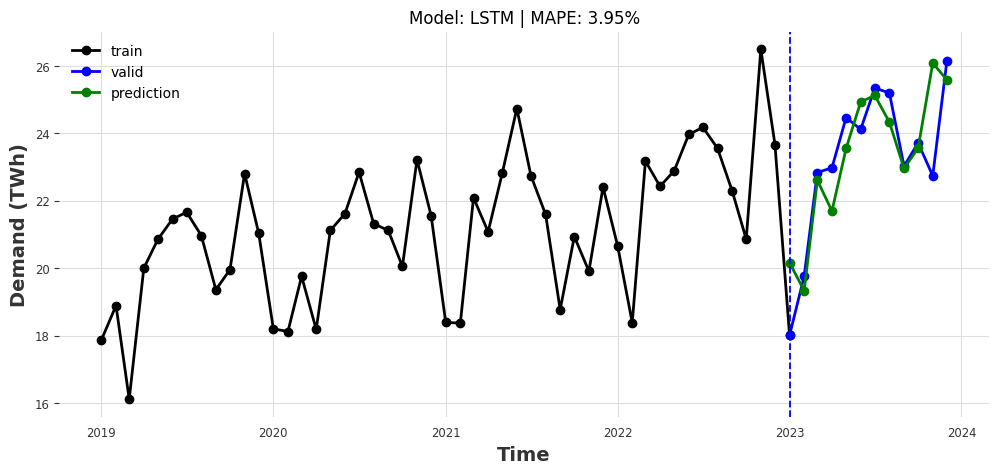

LSTM : 
MAPE : 3.9493
RMSPE : 0.0606
RMSE : 1.3037
R squared : 0.6557


In [22]:
if show_callback:
    loss_tracker.train_losses = []
    loss_tracker.val_losses = []
res, model_RNN = run_RNN("LSTM")

In [28]:
model_RNN

RNNModel(model=LSTM, hidden_dim=175, n_rnn_layers=1, dropout=0.2, training_length=8, model_name=LSTM RNN, input_chunk_length=7, output_chunk_length=1, batch_size=64, n_epochs=184, optimizer_kwargs={'lr': 0.001}, random_state=42, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossTracker object at 0x0000017CE204ACD0>]})

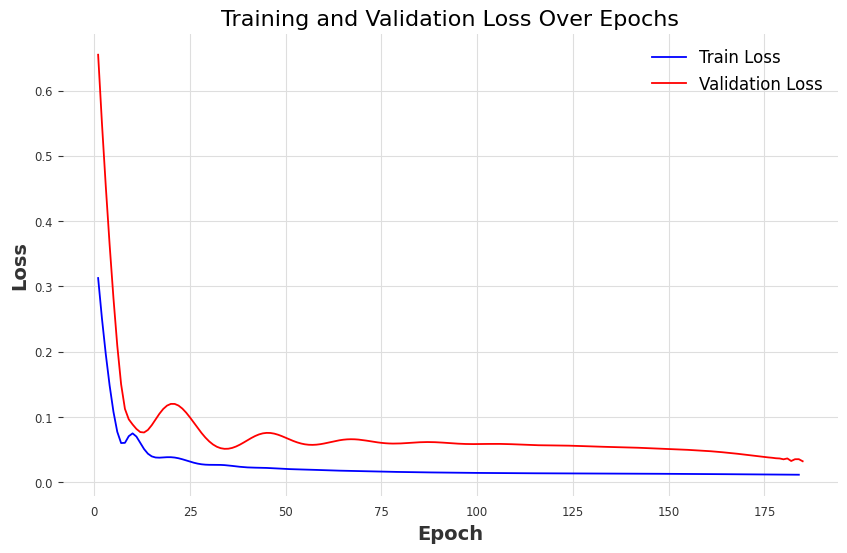

In [23]:
if show_callback:
    epochs = range(1, len(loss_tracker.train_losses) + 1) 

    plt.figure(figsize=(10, 6)) 
    plt.plot(epochs, loss_tracker.train_losses, label="Train Loss", color="blue")

    epochs = range(1, len(loss_tracker.val_losses) + 1)  
    plt.plot(epochs, loss_tracker.val_losses, label="Validation Loss", color="red")

    plt.title("Training and Validation Loss Over Epochs", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [24]:
model_RNN.fit(val_trf, future_covariates=covariates, verbose=True)
test_pred_data = model_RNN.predict(n=10, future_covariates=covariates)
test_pred_data = [trf.inverse_transform(p) for p in test_pred_data] if isinstance(test_pred_data, list) else trf.inverse_transform(test_pred_data)
res_acc = accuracy_metrics(test_pred_data, test)    
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE : 7.1826
RMSPE : 0.0746
RMSE : 1.8315
R squared : 0.0924


In [25]:
# model_RNN.save("save_model/trained_model.darts")
# joblib.dump(trf, "save_model/data_scaler.pkl")
# joblib.dump(covariates, "save_model/covariates_scaler.pkl")

In [26]:
def plot_fitted_test(pred, act, model_name):
    act2 = act.slice(act.start_time(), pred.end_time())
    split_point = int(len(act) - len(pred))  
    split_time = act2.time_index[split_point]
    act2_first_half = act2[:split_point + 1]
    act2_second_half = act2[split_point:]

    plt.figure(figsize=(12, 5))
    act2_first_half.plot(label='train', marker='o', color='black')
    act2_second_half.plot(label='test', marker='o', color='blue')
    pred.plot(label='prediction', marker='o', color='green')
    plt.axvline(x=split_time, color='blue', linestyle='--')

    plt_title = "Model: {0}"
    plt.title(plt_title.format(model_name) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Demand (TWh)', fontsize=14)
    plt.show()

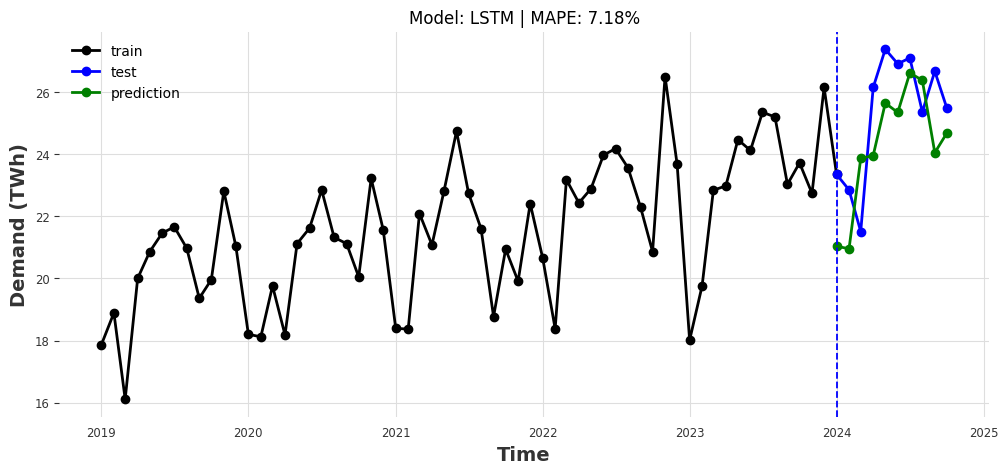

In [27]:
ts_trf_inv = [trf.inverse_transform(t) for t in ts_trf] if isinstance(ts_trf, list) else trf.inverse_transform(ts_trf)
plot_fitted_test(test_pred_data, ts_trf_inv, 'LSTM')